<a href="https://colab.research.google.com/github/otanet/LangChain_Summarization_202304/blob/main/LangChain_GraphGPT_ota_20230425.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **概要: LangChainによる小説のあらすじの自動生成**を試しました。
### **GraphGPT**で可視化して、**Wikipediaのあらすじ**と**LangChainによるあらすじ**とを比較したものです。
#### **元データ**は**芥川竜之介の『蜘蛛の糸』**青空文庫(3236文字)です。
#### **LangChain**で下記の2つのタイプの自動要約を試してみました。  
#### 1)**The map_reduce Chain** 
#### 2) **The refine Chain**
#### ※1 **The stuff Chain**は文字数の関係から省きました。    
#### **評価方法**はカジュアルに、Wikipediaのナレッジグラフで表したあらすじとLangChainの2つタイプのナレッジグラフで表したものとをぱっと見で全体的に網羅しているかを考察してみました。    
#### ※2 要約もニュース記事や小説、論文など、それぞれで異なる役割が与えられており、今回の小説の自動要約は全体的な流れを網羅的にした記述と考えております。Wikipediaのが網羅的と位置付けます。



### 目次
#### 1. **The map_reduce Chain**：並列処理型の自動要約  
#### 2. **The refine Chain**：翻訳とオリジナルを繰り返す自動要約  
#### 上記の1.と2.とで、要約の処理過程を可視化し、プロンプトのテンプレートで調整します。
#### (※除外. **The stuff Chain**: 抽象型要約、文字数制限のため) 
#### 3. 1.と2.の結果をGraphGPTで可視化
#### 4. 考察・まとめ
#### 5. 参考文献・URL一覧

In [1]:
!pip install langchain==0.0.125 openai==0.27.2 tiktoken==0.3.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.2/443.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.9
    Uninstalling

In [2]:
from langchain.document_loaders.image import UnstructuredImageLoader
from langchain import OpenAI, PromptTemplate, LLMChain
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains.summarize import load_summarize_chain
from langchain.docstore.document import Document
from langchain.chat_models import ChatOpenAI
import os

os.environ["OPENAI_API_KEY"] = "*****"

In [3]:
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, max_tokens=1000)
text_splitter = CharacterTextSplitter(chunk_size=1000)

In [4]:
with open("kumono_ito.txt") as f:
    state_of_the_union = f.read()
texts = text_splitter.split_text(state_of_the_union)

docs = [Document(page_content=t) for t in texts]

In [5]:
docs


[Document(page_content='ある日の事でございます。御釈迦様は極楽の蓮池のふちを、独りでぶらぶら御歩きになっていらっしゃいました。池の中に咲いている蓮の花は、みんな玉のようにまっ白で、そのまん中にある金色の蕊からは、何とも云えない好い匂が、絶間なくあたりへ溢れて居ります。極楽は丁度朝なのでございましょう。\n\u3000やがて御釈迦様はその池のふちに御佇みになって、水の面を蔽っている蓮の葉の間から、ふと下の容子を御覧になりました。この極楽の蓮池の下は、丁度｜地獄の底に当って居りますから、水晶のような水を透き徹して、三途の河や針の山の景色が、丁度｜覗き眼鏡を見るように、はっきりと見えるのでございます。\n\u3000するとその地獄の底に、陀多と云う男が一人、ほかの罪人と一しょに蠢いている姿が、御眼に止まりました。この陀多と云う男は、人を殺したり家に火をつけたり、いろいろ悪事を働いた大泥坊でございますが、それでもたった一つ、善い事を致した覚えがございます。と申しますのは、ある時この男が深い林の中を通りますと、小さな蜘蛛が一匹、路ばたを這って行くのが見えました。そこで陀多は早速足を挙げて、踏み殺そうと致しましたが、「いや、いや、これも小さいながら、命のあるものに違いない。その命を無暗にとると云う事は、いくら何でも可哀そうだ。」と、こう急に思い返して、とうとうその蜘蛛を殺さずに助けてやったからでございます。\n\u3000御釈迦様は地獄の容子を御覧になりながら、陀多には蜘蛛を助けた事があるのを御思い出しになりました。そうしてそれだけの善い事をした報には、出来るなら、この男を地獄から救い出してやろうと御考えになりました。幸い、側を見ますと、翡翠のような色をした蓮の葉の上に、極楽の蜘蛛が一匹、美しい銀色の糸をかけて居ります。御釈迦様はその蜘蛛の糸をそっと御手に御取りになって、玉のような白蓮の間から、遥か下にある地獄の底へ、まっすぐにそれを御｜下しなさいました。', metadata={}),
 Document(page_content='こちらは地獄の底の血の池で、ほかの罪人と一しょに、浮いたり沈んだりしていた陀多でございます。何しろどちらを見ても、まっ暗で、たまにそのくら暗からぼんやり浮き上っているものがあると思いますと、それは恐しい針の山の針が光るので

#### 『蜘蛛の糸』2847文字

#### Wikipediaのあらすじとその文字数
#### 釈迦はある日の朝、極楽を散歩中に蓮池を通して下の地獄を覗き見た。罪人どもが苦しんでいる中にカンダタ（犍陀多）という男を見つけた。カンダタは殺人や放火もした泥棒であったが、過去に一度だけ善行を成したことがあった。それは林で小さな蜘蛛を踏み殺しかけて止め、命を助けたことだった。それを思い出した釈迦は、彼を地獄から救い出してやろうと、一本の蜘蛛の糸をカンダタめがけて下ろした。暗い地獄で天から垂れて来た蜘蛛の糸を見たカンダタは、この糸を登れば地獄から出られると考え、糸につかまって昇り始めた。ところが途中で疲れてふと下を見下ろすと、数多の罪人達が自分の下から続いてくる。このままでは重みで糸が切れてしまうと思ったカンダタは、下に向かって大声で「この蜘蛛の糸は己（おれ）のものだぞ。」「お前たちは一体誰に聞いて登って来た。」「下りろ。下りろ。」と喚いた。その途端、蜘蛛の糸がカンダタの真上の部分で切れ、カンダタは再び地獄の底に堕ちてしまった。無慈悲に自分だけ助かろうとし、結局元の地獄へ堕ちてしまったカンダタを浅ましく思ったのか、それを見ていた釈尊は悲しそうな顔をして蓮池から立ち去った。
#### 491文字


### WikipediaのGraphGPTによる可視化(Knowledge　Graph)
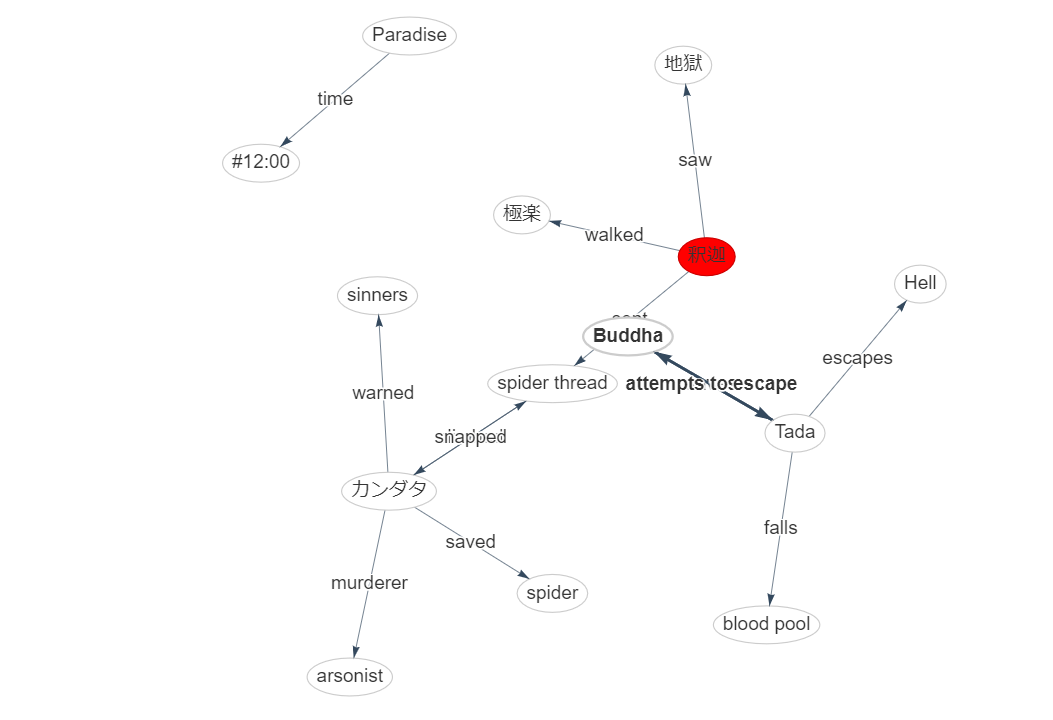

In [8]:
# 1. The map_reduce Chain：並列処理型の自動要約
%%time
chain = load_summarize_chain(llm, chain_type="map_reduce")
chain.run(docs)


CPU times: user 707 ms, sys: 107 ms, total: 814 ms
Wall time: 26.9 s


'Buddha saves a sinner named Tada from hell by lowering a spider thread to him. Tada tries to climb it to escape but fails, causing the thread to break and him to fall back into the pool of blood. Buddha feels sad but the lotus flowers in paradise remain unaffected. It is close to noon in paradise.'

### 日本語訳(The map_reduce Chainの自動要約)
### ブッダは蜘蛛の糸を彼に降ろすことによって、多田という罪人を地獄から救います。多田はそれを登って逃げようとしましたが失敗し、糸が切れて血のプールに落ちました。ブッダは悲しんでいますが、極楽の蓮の花は影響を受けません。楽園の正午近くです。(117文字)

### The map_reduce ChainのGraphGPTによる可視化(Knowledge　Graph)
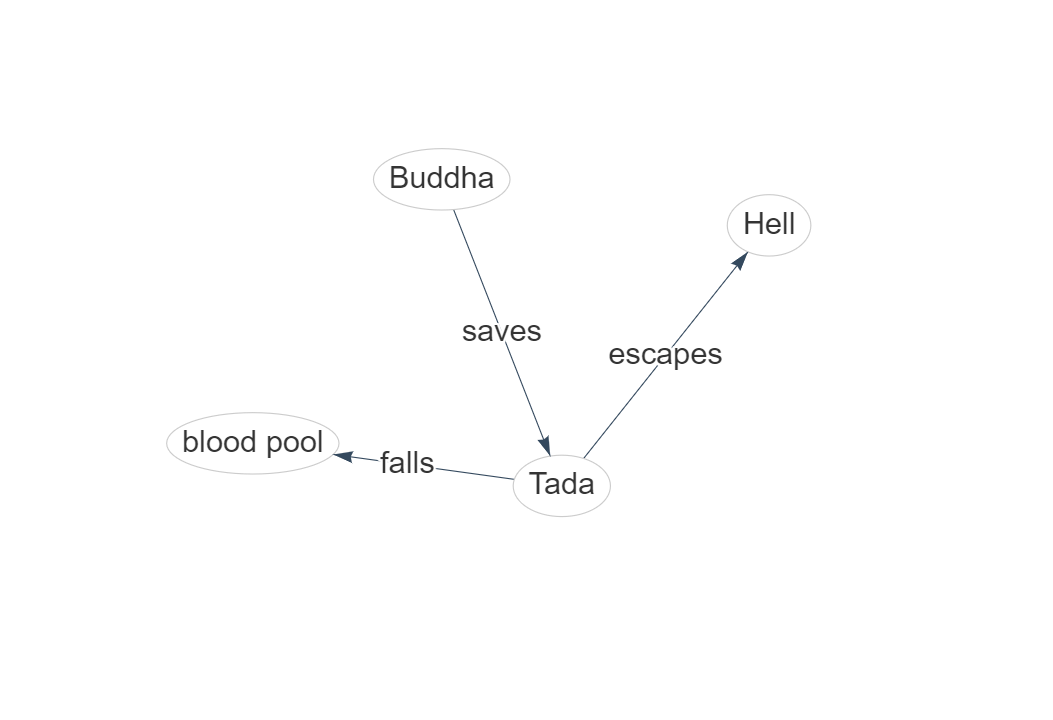

#### Wikipediaのあらすじ（491文字）と1. The map_reduce Chain との比較
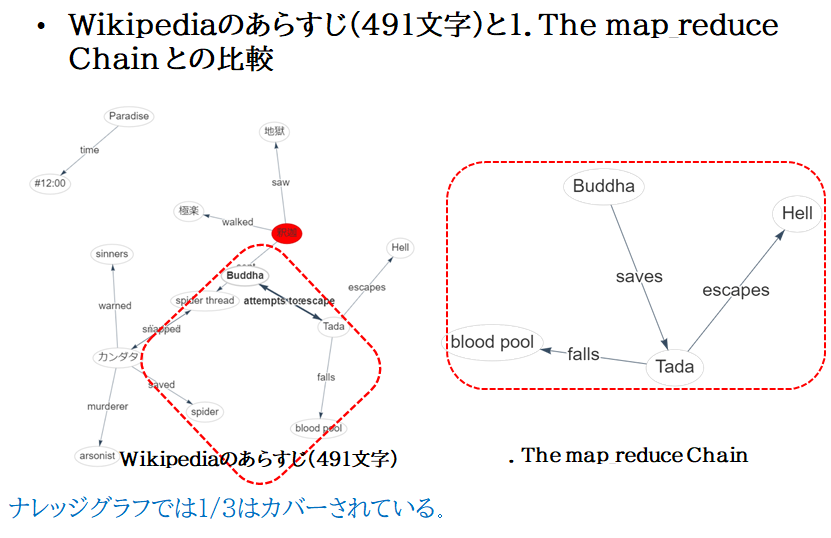


#### 要約の処理過程を可視化
#### 1. The map_reduce Chain：並列処理型の自動要約

In [9]:
#map_reduceでの処理過程の可視化
chain = load_summarize_chain(llm, chain_type="map_reduce", verbose=True)
chain.run(docs)



> Entering new MapReduceDocumentsChain chain...
Prompt after formatting:
Write a concise summary of the following:


"ある日の事でございます。御釈迦様は極楽の蓮池のふちを、独りでぶらぶら御歩きになっていらっしゃいました。池の中に咲いている蓮の花は、みんな玉のようにまっ白で、そのまん中にある金色の蕊からは、何とも云えない好い匂が、絶間なくあたりへ溢れて居ります。極楽は丁度朝なのでございましょう。
　やがて御釈迦様はその池のふちに御佇みになって、水の面を蔽っている蓮の葉の間から、ふと下の容子を御覧になりました。この極楽の蓮池の下は、丁度｜地獄の底に当って居りますから、水晶のような水を透き徹して、三途の河や針の山の景色が、丁度｜覗き眼鏡を見るように、はっきりと見えるのでございます。
　するとその地獄の底に、陀多と云う男が一人、ほかの罪人と一しょに蠢いている姿が、御眼に止まりました。この陀多と云う男は、人を殺したり家に火をつけたり、いろいろ悪事を働いた大泥坊でございますが、それでもたった一つ、善い事を致した覚えがございます。と申しますのは、ある時この男が深い林の中を通りますと、小さな蜘蛛が一匹、路ばたを這って行くのが見えました。そこで陀多は早速足を挙げて、踏み殺そうと致しましたが、「いや、いや、これも小さいながら、命のあるものに違いない。その命を無暗にとると云う事は、いくら何でも可哀そうだ。」と、こう急に思い返して、とうとうその蜘蛛を殺さずに助けてやったからでございます。
　御釈迦様は地獄の容子を御覧になりながら、陀多には蜘蛛を助けた事があるのを御思い出しになりました。そうしてそれだけの善い事をした報には、出来るなら、この男を地獄から救い出してやろうと御考えになりました。幸い、側を見ますと、翡翠のような色をした蓮の葉の上に、極楽の蜘蛛が一匹、美しい銀色の糸をかけて居ります。御釈迦様はその蜘蛛の糸をそっと御手に御取りになって、玉のような白蓮の間から、遥か下にある地獄の底へ、まっすぐにそれを御｜下しなさいました。"


CONCISE SUMMARY:
Prompt after formatting:
Write a concise summary of t



> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"One day, Buddha was walking around a lotus pond in paradise when he saw a man named Tada in hell. Tada had committed many sins but had once saved a spider's life. Buddha decided to save Tada from hell and saw a spider on a jade-colored lotus leaf with a silver thread. Buddha took the thread and lowered it down to Tada in hell, saving him.

The story is about a sinner named Tada who is floating in a pool of blood in hell. He sees a silver spider thread hanging from the sky and decides to climb it to escape. However, he becomes tired and stops to rest, only to realize that many other sinners are climbing the thread behind him. Tada tries to stop them, but the thread breaks, and he falls back into the pool of blood. The story ends with the spider thread still hanging in the sky.

The Buddha watches as Tada sinks into the blood pool of hell due to his cruel heart, causing the Buddha to 


> Finished chain.

> Finished chain.


'Buddha saves a sinner named Tada from hell by lowering a spider thread to him. Tada tries to climb it to escape but fails, causing the thread to break and him to fall back into the pool of blood. Buddha feels sad but the lotus flowers in paradise remain unaffected. It is close to noon in paradise.'

### ブッダは蜘蛛の糸を彼に降ろすことによって、多田という罪人を地獄から救います。多田はそれを登って逃げようとしましたが失敗し、糸が切れて血のプールに落ちました。ブッダは悲しんでいますが、極楽の蓮の花は影響を受けません。楽園の正午近くです。(117文字)

### GraphGPTによる可視化(Knowledge Graph)

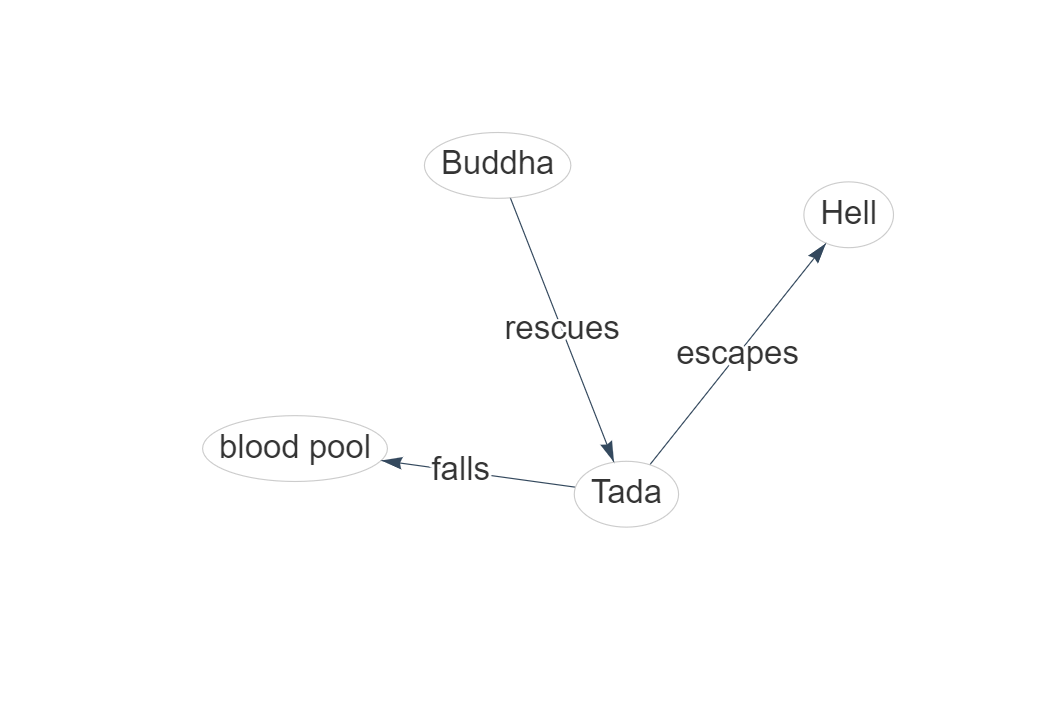

In [10]:
# プロンプトをテンプレートを用いてカスタマイズ(map_reduce)
from langchain import PromptTemplate

template = """
次の文章を日本語で簡潔に全体のあらすじを500文字程度で記してください。
文章：{text}
"""

PROMPT = PromptTemplate(
    input_variables=["text"],
    template=template,
)

In [11]:
chain = load_summarize_chain(llm, chain_type="map_reduce", map_prompt=PROMPT, combine_prompt=PROMPT, verbose=True)

In [12]:
chain.run(docs)



> Entering new MapReduceDocumentsChain chain...
Prompt after formatting:

次の文章を日本語で簡潔に全体のあらすじを500文字程度で記してください。
文章：ある日の事でございます。御釈迦様は極楽の蓮池のふちを、独りでぶらぶら御歩きになっていらっしゃいました。池の中に咲いている蓮の花は、みんな玉のようにまっ白で、そのまん中にある金色の蕊からは、何とも云えない好い匂が、絶間なくあたりへ溢れて居ります。極楽は丁度朝なのでございましょう。
　やがて御釈迦様はその池のふちに御佇みになって、水の面を蔽っている蓮の葉の間から、ふと下の容子を御覧になりました。この極楽の蓮池の下は、丁度｜地獄の底に当って居りますから、水晶のような水を透き徹して、三途の河や針の山の景色が、丁度｜覗き眼鏡を見るように、はっきりと見えるのでございます。
　するとその地獄の底に、陀多と云う男が一人、ほかの罪人と一しょに蠢いている姿が、御眼に止まりました。この陀多と云う男は、人を殺したり家に火をつけたり、いろいろ悪事を働いた大泥坊でございますが、それでもたった一つ、善い事を致した覚えがございます。と申しますのは、ある時この男が深い林の中を通りますと、小さな蜘蛛が一匹、路ばたを這って行くのが見えました。そこで陀多は早速足を挙げて、踏み殺そうと致しましたが、「いや、いや、これも小さいながら、命のあるものに違いない。その命を無暗にとると云う事は、いくら何でも可哀そうだ。」と、こう急に思い返して、とうとうその蜘蛛を殺さずに助けてやったからでございます。
　御釈迦様は地獄の容子を御覧になりながら、陀多には蜘蛛を助けた事があるのを御思い出しになりました。そうしてそれだけの善い事をした報には、出来るなら、この男を地獄から救い出してやろうと御考えになりました。幸い、側を見ますと、翡翠のような色をした蓮の葉の上に、極楽の蜘蛛が一匹、美しい銀色の糸をかけて居ります。御釈迦様はその蜘蛛の糸をそっと御手に御取りになって、玉のような白蓮の間から、遥か下にある地獄の底へ、まっすぐにそれを御｜下しなさいました。

Prompt after formatting:

次の文章を日本語で簡潔に全体のあらすじを500文字程度で記してください。
文章：こちらは地獄の底の血

'御釈迦様が極楽の蓮池で散歩していたところ、地獄で苦しむ陀多の姿を見かける。陀多は蜘蛛を助けたことがあるため、御釈迦様は極楽の蜘蛛の糸を使って彼を救い出すことを決める。しかし、陀多は糸が断れて地獄に落ちてしまい、極楽へ行くチャンスを逃してしまう。御釈迦様は陀多の無慈悲な心を嘆き、極楽の蓮池の美しさに癒されながら散歩を続ける。'

### GraphGPTによる可視化: The map_reduce Chain(テンプレ使用)
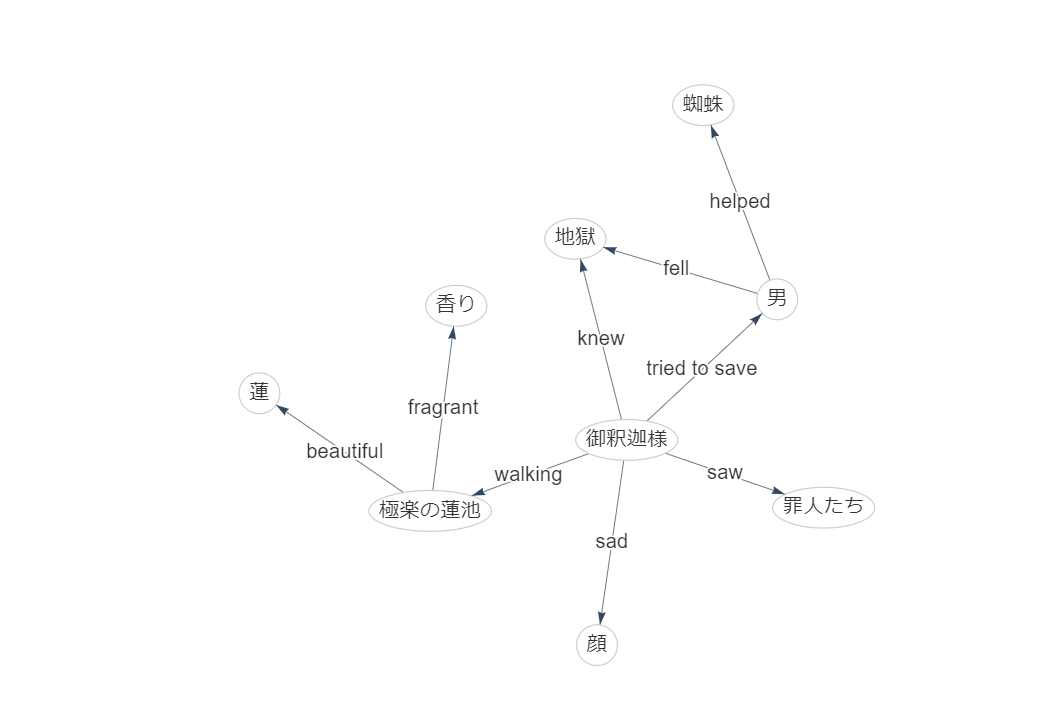

In [13]:
# 2. The refine Chain：翻訳とオリジナルを繰り返す自動要約
%%time
chain = load_summarize_chain(llm, chain_type="refine", verbose=True)
chain.run(docs)




> Entering new RefineDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"ある日の事でございます。御釈迦様は極楽の蓮池のふちを、独りでぶらぶら御歩きになっていらっしゃいました。池の中に咲いている蓮の花は、みんな玉のようにまっ白で、そのまん中にある金色の蕊からは、何とも云えない好い匂が、絶間なくあたりへ溢れて居ります。極楽は丁度朝なのでございましょう。
　やがて御釈迦様はその池のふちに御佇みになって、水の面を蔽っている蓮の葉の間から、ふと下の容子を御覧になりました。この極楽の蓮池の下は、丁度｜地獄の底に当って居りますから、水晶のような水を透き徹して、三途の河や針の山の景色が、丁度｜覗き眼鏡を見るように、はっきりと見えるのでございます。
　するとその地獄の底に、陀多と云う男が一人、ほかの罪人と一しょに蠢いている姿が、御眼に止まりました。この陀多と云う男は、人を殺したり家に火をつけたり、いろいろ悪事を働いた大泥坊でございますが、それでもたった一つ、善い事を致した覚えがございます。と申しますのは、ある時この男が深い林の中を通りますと、小さな蜘蛛が一匹、路ばたを這って行くのが見えました。そこで陀多は早速足を挙げて、踏み殺そうと致しましたが、「いや、いや、これも小さいながら、命のあるものに違いない。その命を無暗にとると云う事は、いくら何でも可哀そうだ。」と、こう急に思い返して、とうとうその蜘蛛を殺さずに助けてやったからでございます。
　御釈迦様は地獄の容子を御覧になりながら、陀多には蜘蛛を助けた事があるのを御思い出しになりました。そうしてそれだけの善い事をした報には、出来るなら、この男を地獄から救い出してやろうと御考えになりました。幸い、側を見ますと、翡翠のような色をした蓮の葉の上に、極楽の蜘蛛が一匹、美しい銀色の糸をかけて居ります。御釈迦様はその蜘蛛の糸をそっと御手に御取りになって、玉のような白蓮の間から、遥か下にある地獄の底へ、まっすぐにそれを御｜下しなさいました。"


CONCISE SUMMARY:

> Finished chain.




"One day, Buddha saw a man named Tada in hell and decided to save him. Tada had once saved a spider's life, so Buddha took a silver thread from a spider on a lotus leaf in paradise and lowered it down to Tada in hell, saving him. Tada grabbed the thread and began to climb up towards paradise, but he grew tired and stopped to rest. Looking down, he saw countless other sinners climbing up the thread behind him. Tada yelled at them to stop, but the weight of the climbers caused the thread to break, and Tada fell back into hell. Buddha watched sadly as Tada sank into the blood pool of hell, realizing that Tada's lack of compassion had caused his downfall. Meanwhile, the lotus flowers in paradise continued to bloom and emit a sweet fragrance."

### The refine Chainの日本語訳
ある日、仏陀は多田という男が地獄にいるのを見て、彼を救う決心をしました。多田はかつて蜘蛛の命を救ったので、釈迦は極楽の蓮の葉にいる蜘蛛から銀の糸を取り、それを地獄の多田に降ろして救った。しかし、タダの残酷な心は彼を地獄に落とした.一方、楽園の蓮の花は、多田の運命に左右されることなく、甘い香りを放ちながら咲き続けていた。(160文字)

### GraphGPTによる可視化(The refine Chain(日本語訳)の可視化))
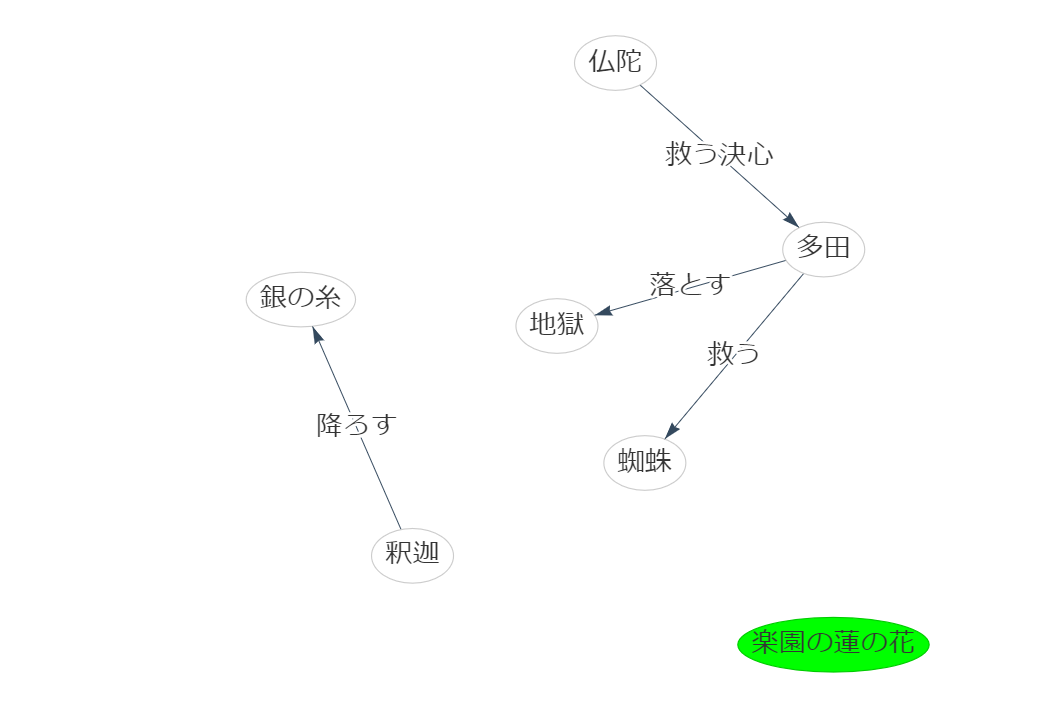

### The map_reduce Chainテンプレート・カスタマイズとの比較
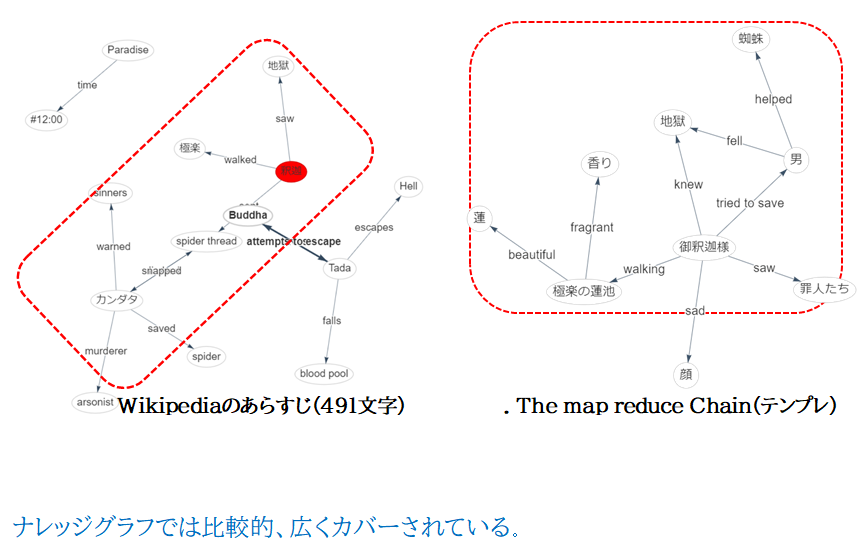

### The refine Chain(テンプレート・カスタマイズ)

In [15]:
prompt_template = """次の文章の簡潔に全体のあらすじを400文字程度で記してください:

{text}

簡潔な日本語のあらすじ:"""
PROMPT = PromptTemplate(template=prompt_template, input_variables=["text"])


refine_template = (
    
    "あなたの仕事は最終的なあらすじを400文字程度で作ることです\n"
    "途中までのあらすじがあります: {existing_answer}\n"
    "必要に応じて下記の文章を使い、さらに良いあらすじを作成してください\n"
    "------------\n"
    "{text}\n"
    "------------\n"
    "与えられた文章を踏まえて、日本語であらすじを改善してください"
    "与えられた文章が有用でない場合、途中までの文章を返してください"
)
refine_prompt = PromptTemplate(
    input_variables=["existing_answer", "text"],
    template=refine_template,
)

In [16]:
chain = load_summarize_chain(llm, chain_type="refine", question_prompt=PROMPT, refine_prompt=refine_prompt, verbose=True)
chain.run(docs)



> Entering new RefineDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
次の文章の簡潔に全体のあらすじを500文字程度で記してください:

ある日の事でございます。御釈迦様は極楽の蓮池のふちを、独りでぶらぶら御歩きになっていらっしゃいました。池の中に咲いている蓮の花は、みんな玉のようにまっ白で、そのまん中にある金色の蕊からは、何とも云えない好い匂が、絶間なくあたりへ溢れて居ります。極楽は丁度朝なのでございましょう。
　やがて御釈迦様はその池のふちに御佇みになって、水の面を蔽っている蓮の葉の間から、ふと下の容子を御覧になりました。この極楽の蓮池の下は、丁度｜地獄の底に当って居りますから、水晶のような水を透き徹して、三途の河や針の山の景色が、丁度｜覗き眼鏡を見るように、はっきりと見えるのでございます。
　するとその地獄の底に、陀多と云う男が一人、ほかの罪人と一しょに蠢いている姿が、御眼に止まりました。この陀多と云う男は、人を殺したり家に火をつけたり、いろいろ悪事を働いた大泥坊でございますが、それでもたった一つ、善い事を致した覚えがございます。と申しますのは、ある時この男が深い林の中を通りますと、小さな蜘蛛が一匹、路ばたを這って行くのが見えました。そこで陀多は早速足を挙げて、踏み殺そうと致しましたが、「いや、いや、これも小さいながら、命のあるものに違いない。その命を無暗にとると云う事は、いくら何でも可哀そうだ。」と、こう急に思い返して、とうとうその蜘蛛を殺さずに助けてやったからでございます。
　御釈迦様は地獄の容子を御覧になりながら、陀多には蜘蛛を助けた事があるのを御思い出しになりました。そうしてそれだけの善い事をした報には、出来るなら、この男を地獄から救い出してやろうと御考えになりました。幸い、側を見ますと、翡翠のような色をした蓮の葉の上に、極楽の蜘蛛が一匹、美しい銀色の糸をかけて居ります。御釈迦様はその蜘蛛の糸をそっと御手に御取りになって、玉のような白蓮の間から、遥か下にある地獄の底へ、まっすぐにそれを御｜下しなさいました。

簡潔な日本語のあらすじ:

> Finished chain.


> Entering new LL

'御釈迦様は地獄の底にいる罪人たちを見て回り、陀多という男を見つけます。陀多は悪事を働いたが、蜘蛛を助けたことがあるため、御釈迦様はその善行を思い出し、陀多を救い出すことを決めます。御釈迦様は極楽の蓮池に行き、蜘蛛の糸を使って陀多を救い出します。陀多は喜び、蜘蛛の糸につかまって極楽への道をのぼり始めます。しかし、途中で疲れ果ててしまい、休憩するために糸にぶら下がります。その時、他の罪人たちが陀多の後を追って蜘蛛の糸をのぼってきます。陀多は彼らを追い払おうとするが、糸が断れて地獄に落ちてしまいます。御釈迦様は極楽の蓮池のふちに立ち、陀多が地獄に落ちたことに悲しみます。しかし、極楽の蓮池の蓮は、御釈迦様の御足のまわりに、ゆらゆら萼を動かして、そのまん中にある金色の蕊からは、何とも云えない好い匂が、絶間なくあたりへ溢れて居ります。'

#### The refine Chain(テンプレ・カスタマイズ)のあらすじ本文
####  御釈迦様は地獄の底にいる罪人たちを見て回り、陀多という男を見つけます。陀多は悪事を働いたが、蜘蛛を助けたことがあるため、御釈迦様はその善行を思い出し、陀多を救い出すことを決めます。御釈迦様は極楽の蓮池に行き、蜘蛛の糸を使って陀多を救い出します。陀多は喜び、蜘蛛の糸につかまって極楽への道をのぼり始めます。しかし、途中で疲れ果ててしまい、休憩するために糸にぶら下がります。その時、他の罪人たちが陀多の後を追って蜘蛛の糸をのぼってきます。陀多は彼らを追い払おうとするが、糸が断れて地獄に落ちてしまいます。御釈迦様は極楽の蓮池のふちに立ち、陀多が地獄に落ちたことに悲しみます。しかし、極楽の蓮池の蓮は、御釈迦様の御足のまわりに、ゆらゆら萼を動かして、そのまん中にある金色の蕊からは、何とも云えない好い匂が、絶間なくあたりへ溢れて居ります。

#### GraphGPTによる可視化(The refine Chain(テンプレ)の可視化))
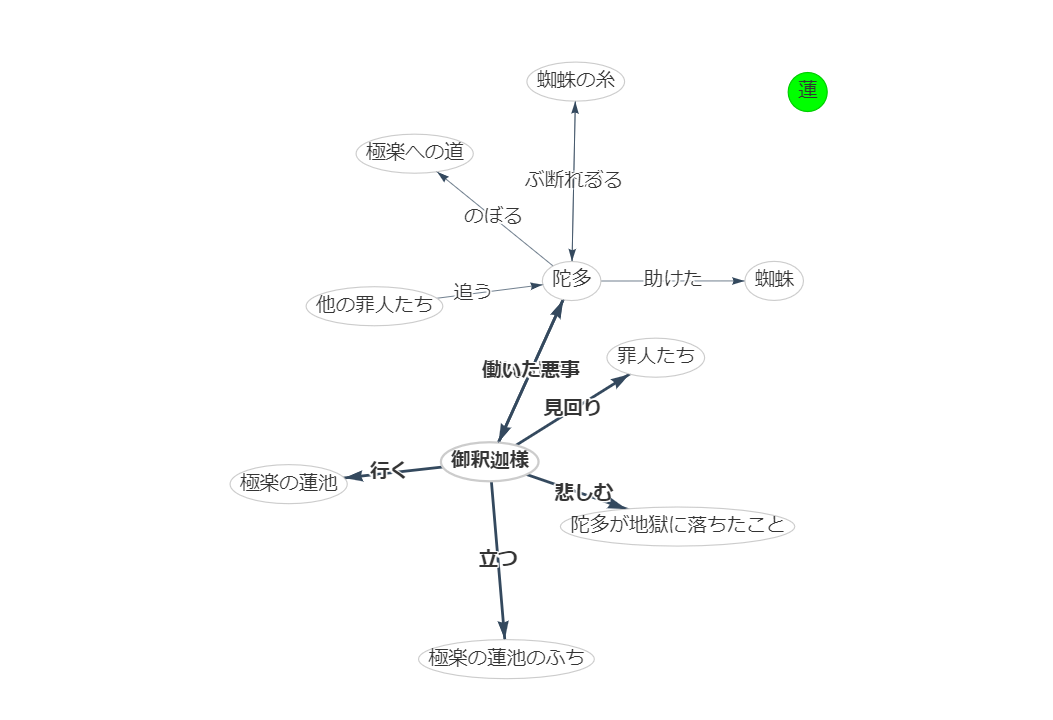

#### The refine Chainテンプレート・カスタマイズとの比較
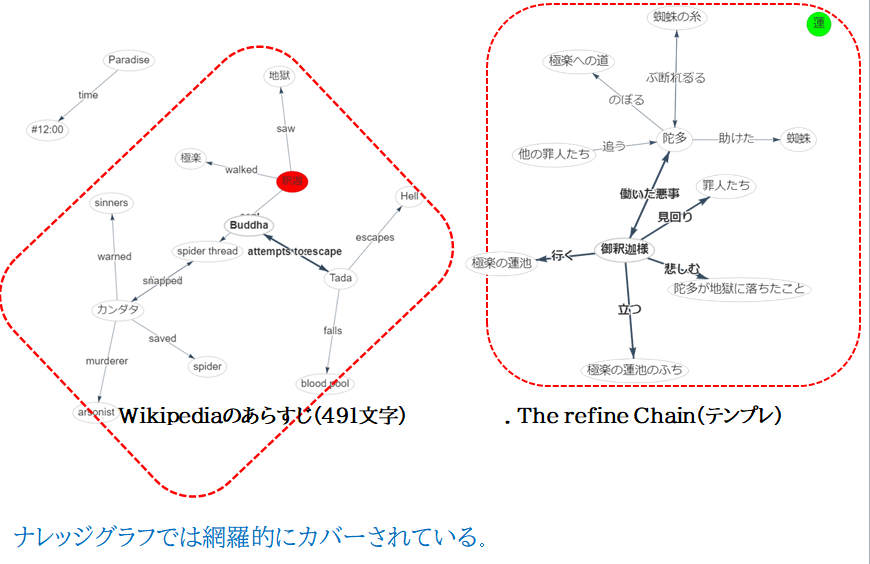

#### 考察・まとめ
#### 1) The refine Chainでカスタマイズしたテンプレートを用いたあらすじが、最も網羅的であった。
#### 2) 1)に対して、The map_reduce Chainは並列要約のため、やや部分的になりがちであることが、可視化されたKnowledge Graphでも見て取れた。
#### 3) 小説のあらすじは、全知的な網羅性がその特徴として挙げられ、GraphGPTで可視化して比較すると直感的に捉えることができ、有効であった。
#### 4) 今後の課題として、小説以外の適用が挙げられる。例えば、論文の概要など研究成果の部分を記すことでもあり、またニュース記事などは記者の強調したい部分がその要約に積み込まれる。これらを踏まえて、適用してゆきたい。